In [ ]:
%pip install -i https://test.pypi.org/simple/ VASA==0.0.4

In [1]:
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sys.path.append(os.path.abspath(os.path.join(os.pardir)))
from VASA import VASA

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# CBG Map of California
counties_map = gpd.GeoDataFrame \
    .from_features(gpd.read_file("../data/ca_cbg")) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

counties_map = counties_map[counties_map.ALAND > 0]

In [3]:
#Lake Fire 2019 Data
fire2019 = pd.read_csv("../data/lakefire2019_data.csv")
fire2019.origin_census_block_group = "0" + fire2019.origin_census_block_group.astype(str)

In [7]:
# Lake Fire Shapefile
lake_fire = gpd.read_file("../data/lake_fire") \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

unique_cbgs = np.unique(fire2019.origin_census_block_group)
unique_tracts = np.unique([g[:8] for g in unique_cbgs])
unique_counties = np.unique([g[:5] for g in unique_tracts])

fig, ax = plt.subplots(figsize=(10, 10))

tract_map = counties_map[[(cbg[:8] in unique_tracts) for cbg in counties_map.GEOID]]
base_map = counties_map[[(cbg[:5] in unique_counties) for cbg in counties_map.GEOID]].copy()

base_map["c"] = "gray"
base_map.loc[[(cbg[:8] in unique_tracts) for cbg in base_map.GEOID], "c"] = "blue"
base_map.loc[[(cbg in unique_cbgs) for cbg in base_map.GEOID], "c"] = "green"

base_map.plot(ax=ax, color=base_map["c"])
lake_fire.plot(ax=ax, color="red")

plt.savefig("fire_weights_filled_in_data.png")
plt.close(fig)

![data levels](fire_weights_filled_in_data.png)

### Blue = filled in cbgs
### Green = cbgs we had data for
### Red = Lake fire location

In [4]:
v = VASA(
    df=fire2019[["origin_census_block_group", "date_range_start", "distance_traveled_from_home"]],
    gdf=counties_map,
    group_summary=lambda g: g[:5],  # county level
    df_group_col="origin_census_block_group",
    gdf_group_col="GEOID",
    date_col="date_range_start",
    temp_res="week",
    date_format="%Y-%m-%d %H:%M:%S" # %z
)

v.filter_group()
v.group()

In [5]:
del fire2019

In [6]:
v.fill_missing()

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

v.show_weights_connection(k=10, ax=ax)

plt.savefig("k_weights.png")
plt.close(fig)

![](k_weights.png)

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

v.show_weights_connection(type="queens", ax=ax)

plt.savefig("queens_weights.png")
plt.close(fig)

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 1796, 5276, 5962, 9872.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')


![](queens_weights.png)

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

v.show_weights_connection(k=2, type="union", ax=ax)

plt.savefig("union_weights.png")
plt.close(fig)

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 66 disconnected components.
  warnings.warn(message)
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 1796, 5276, 5962, 9872.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')


In [8]:
v.W.n_components

1

![](union_weights.png)

In [ ]:
v.show_weights_connection(band=10_000)

In [7]:
comparison = pd.DataFrame()

for k in range(2, 22, 2):
    print(k)

    v.create_w(k=k)
    k_disconnected = v.W.n_components
    
    v.create_w(k=k, type="union")
    ku_disconnected = v.W.n_components

    comparison = comparison.append(dict(k=k, ks=k_disconnected, ks_union=ku_disconnected), ignore_index=True)

2


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 66 disconnected components.
  warnings.warn(message)
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 1796, 5276, 5962, 9872.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
4


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
6


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
8


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
10
('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
12
('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
14
('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')
16
('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')


In [8]:
comparison

,k,ks,ks_union
0,2.0,66.0,1.0
1,4.0,9.0,1.0
2,6.0,4.0,1.0
3,8.0,2.0,1.0
4,10.0,1.0,1.0
5,12.0,1.0,1.0
6,14.0,1.0,1.0
7,16.0,1.0,1.0
8,18.0,1.0,1.0
9,20.0,1.0,1.0


<AxesSubplot:xlabel='k', ylabel='value'>

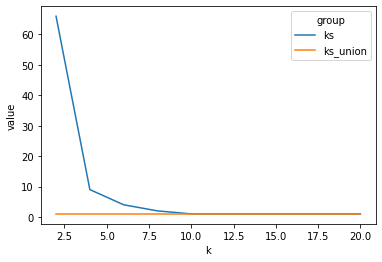

In [9]:
import seaborn as sns

sns.lineplot(
    data=pd.melt(comparison, id_vars=["k"], value_vars=["ks", "ks_union"], var_name="group"),
    x="k",
    y="value",
    hue="group"
)